In [1]:
# %load_ext autoreload
# %autoreload 2


In [2]:
# Modify path so this notebook can find the utils package.

import sys
sys.path.append('..')


In [3]:
# Standard imports:

import autograd.numpy as np
import autograd.scipy as sp
import pandas as pd
import matplotlib.pyplot as plt


## Target distributions:


**Benchmark from AM207 Exercise 15:**

Bayesian logistic regression model:
$$\begin{align}
    w &\sim \mathcal{N}(0, 1) \\
    Y^{(n)} | w &\sim Ber(\text{sigm}(wX^{(n)} + 10)) \\
\end{align}$$

where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$.

The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):

<img src="https://i.ibb.co/R2PP4yC/logistic-posterior.png" style='width:30%;'>


In [4]:
# Define benchmark:

from utils.functions import sigmoid, log_bernoulli, log_gaussian

def log_posterior_benchmark(W):
    X = np.array([[-20.0]])
    Y = np.array([[1.0]])
    intercept = 10.0
    log_prior_term = np.sum( log_gaussian(W, mu=0.0, sigma=1.0) ,axis=-1)
    log_lhood_term = np.sum( log_bernoulli(k=Y,p=sigmoid(np.dot(W,X.T)+intercept),clip=True) ,axis=-1)
    return log_prior_term + log_lhood_term


## BBVI:


_(Adapted from AM207 Lecture 17 slides + Exercise 17)_

$$\begin{align}
    \text{variational_objective}(\mathbf{W}) &=
    \frac{1}{S} \sum_{s=1}^S
    \underbrace{
        \log \left[p(\epsilon_s^\top \Sigma^{1/2} + \mu)
        \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \epsilon_s^\top \Sigma^{1/2} + \mu)\right]
    }_{\text{log_posterior}(\epsilon_s^\top \Sigma^{1/2} + \mu)}
    + \underbrace{
        -
        \mathbb{E}_{\mathbf{W} \sim \mathcal{N}(\mu, \Sigma )}
        \left[\log \mathcal{N}(\mathbf{W};\mu, \Sigma ) \right]
    }_{\text{Guassian entropy}} \\
    &\\
    \nabla_{\mu, \Sigma} ELBO(\mathbf{W}) &\approx
    \nabla_{\mu, \Sigma} \left[ \text{variational_objective}(\mathbf{W}) \right] \\
\end{align}$$


Iteration 100 : lower bound = -3.0712291607942674, graident magnitude = 6.794834083888097
Iteration 200 : lower bound = -2.183643656817084, graident magnitude = 5.880571018842497
Iteration 300 : lower bound = -1.555468862091939, graident magnitude = 4.865680028566717
Iteration 400 : lower bound = -0.8606074217354747, graident magnitude = 3.5902267022772456
Iteration 500 : lower bound = -0.9979172701216485, graident magnitude = 2.963214680740714
Iteration 600 : lower bound = -0.6925655584773066, graident magnitude = 2.2194161626124638
Iteration 700 : lower bound = -0.6652975314395573, graident magnitude = 1.530789551393849
Iteration 800 : lower bound = -0.5801180477066838, graident magnitude = 1.0062102830274327
Iteration 900 : lower bound = -0.5532625867391763, graident magnitude = 0.7412532094282409
Iteration 1000 : lower bound = -0.5768831472322116, graident magnitude = 0.7024329347950601
Finished in 4 seconds


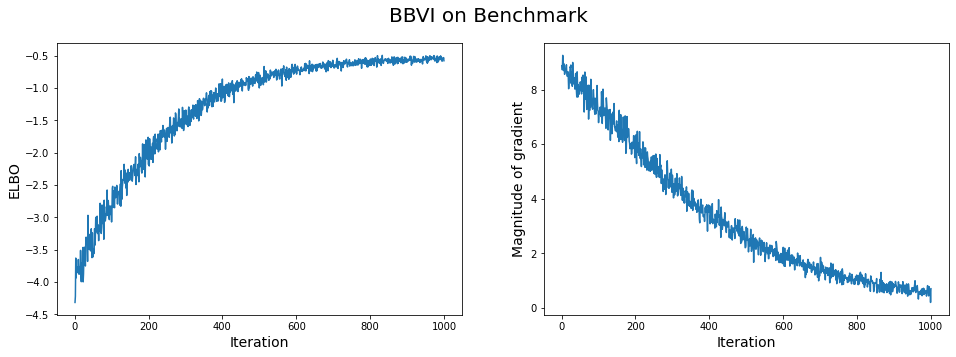

In [5]:
# Perform BBVI on benchmark:

from utils.training import BBVI

bbvi_params_benchmark = {
    'mode' : 'BNN',
    'num_samples' : 2_000,
    'step_size' : 0.001,
    'num_iters' : 1_000,
    'random_seed' : 207,
    'Mu_init' : np.array([0.0]),
    'Sigma_init' : np.array([[1.0]]),
}

bbvi_benchmark = BBVI(log_posterior_benchmark, **bbvi_params_benchmark, progress=100)
Mu, Sigma = bbvi_benchmark.run()

# Plot optimization history:
elbo_hist = bbvi_benchmark.elbo_hist
mag_hist = bbvi_benchmark.magnitude_hist
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
fig.suptitle("BBVI on Benchmark", fontsize=20)
ax1.plot(range(1,1+len(elbo_hist)),elbo_hist)
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("ELBO", fontsize=14)
ax2.plot(range(1,1+len(mag_hist)),mag_hist)
ax2.set_xlabel("Iteration", fontsize=14)
ax2.set_ylabel("Magnitude of gradient", fontsize=14)
plt.show()


## HMC:


_(Copied from AM207 Lecture 14 slides)_

Let $q\in \mathbb{R}^D$. Let $\pi(q)$ be our target distribution so that $U(q) = -\log(\pi(q))$ defines our potential energy function. Let's choose the mass of this system to be a matrix $M = m \mathbf{I}_{D\times D}$. Then the ***Euclidea-Guassian kinetic energy*** function is defined as

$$
K(p) = \frac{1}{2} p^\top M^{-1} p + \frac{1}{2}\log|M| + \frac{D}{2} \log(2\pi)
$$

The Gibbs distribution for $K(p)$ is 

$$
\pi(p) = \frac{1}{Z}\exp\{-K(p)\} = \frac{1}{Z} \frac{1}{(2\pi)^{D/2}|M|^{1/2}} \exp\left\{-\frac{1}{2}p^\top M^{-1} p\right\}
$$

Since $\exp\{-K(p)\}$ is the pdf of the normal distribution $\mathcal{N}(0, M)$, it already integrates to 1, and hence $Z =1$.

Now, the partial derivatives of $H(q, p) = U(q) + K(P)$ with respect to $q$ and $p$ are
\begin{aligned}
\frac{\partial U}{\partial q} &= - \frac{\frac{\partial}{\partial q}\pi(q)}{\pi(q)}\\
\frac{\partial K}{\partial p} &= \frac{1}{m} p
\end{aligned}

Thus, HMC with the above choices becomes

0. start with a random $q^{(0)}\in\mathbb{R}^D$
1. repeat:
    1. (**kick-off**) sample a random momentum from the Gibbs distribution of $K(p)$, i.e. $p^{(current)} \sim \mathcal{N}(0, M)$.
    
    2. (**simulate movement**) simulate Hamiltonian motion for $L$ steps each with time interval $\epsilon$, using the leap-frog integrator. 
  
        1. Repeat for T - 1 times, for $p^{(\text{step } 0)} = p^{(current)}$, $q^{(\text{step } 0)} = q^{(current)}$:
            
            1. (**half-step update for momentum**) $p^{(\text{step } t + 1/2)} \leftarrow  p^{(\text{step } t)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t)})$
            
            2. (**full-step update for momentum**) $q^{(\text{step } t + 1)} \leftarrow q^{(\text{step } t)} + \epsilon \frac{1}{m} p^{(\text{step } t + 1/2)}$
            
            3. (**half-step update for momentum**) $p^{(\text{step } t + 1)} \leftarrow  p^{(\text{step } t + 1/2)} - \epsilon/2 \frac{\partial U}{\partial q}(q^{(\text{step } t + 1)})$

        2. (**reverse momentum**) $p^{(\text{step } T)} \leftarrow -p^{(\text{step } T)}$
  
    3. (**correction for simulation error**) implement Metropolis-Hasting accept mechanism: 
        
        1. compute $\alpha = \min\left(1, \exp\left\{H(q^{(current)}, p^{(current)}) - H(q^{(\text{step } T)}, p^{(\text{step } T)})\right\} \right)$
        
        2. sample $U\sim U(0, 1)$, if $U \leq \alpha$ then accept, else keep old sample.


In [6]:
from utils.training import HMC

hmc_params = {
    'random_seed' : 207,
    'step_size' : 1e-3,     # Suggested : 1e-3
    'leapfrog_steps' : 50,  # Suggested : 50
    'burn_in' : 0.1,        # Suggested : 0.1
    'thinning_factor' : 2,  # Suggested : 2
    'total_samples' : 1_000,
    'position_init' : np.zeros((1)),
}

hmc_benchmark = HMC(log_posterior_benchmark, **hmc_params, progress=100)
samples = hmc_benchmark.sample()
print("Done.")


  iteration 100/2,223 (10 sec): total 100 samples (100.0% acceptance)
  iteration 200/2,223 (10 sec): total 200 samples (100.0% acceptance)
  iteration 300/2,223 (11 sec): total 300 samples (100.0% acceptance)
  iteration 400/2,223 (11 sec): total 400 samples (100.0% acceptance)
  iteration 500/2,223 (11 sec): total 500 samples (100.0% acceptance)
  iteration 600/2,223 (11 sec): total 600 samples (100.0% acceptance)
  iteration 700/2,223 (11 sec): total 700 samples (100.0% acceptance)
  iteration 800/2,223 (11 sec): total 800 samples (100.0% acceptance)
  iteration 900/2,223 (11 sec): total 900 samples (100.0% acceptance)
  iteration 1,000/2,223 (11 sec): total 1,000 samples (100.0% acceptance)
  iteration 1,100/2,223 (11 sec): total 1,100 samples (100.0% acceptance)
  iteration 1,200/2,223 (12 sec): total 1,200 samples (100.0% acceptance)
  iteration 1,300/2,223 (12 sec): total 1,300 samples (100.0% acceptance)
  iteration 1,400/2,223 (12 sec): total 1,400 samples (100.0% acceptance)


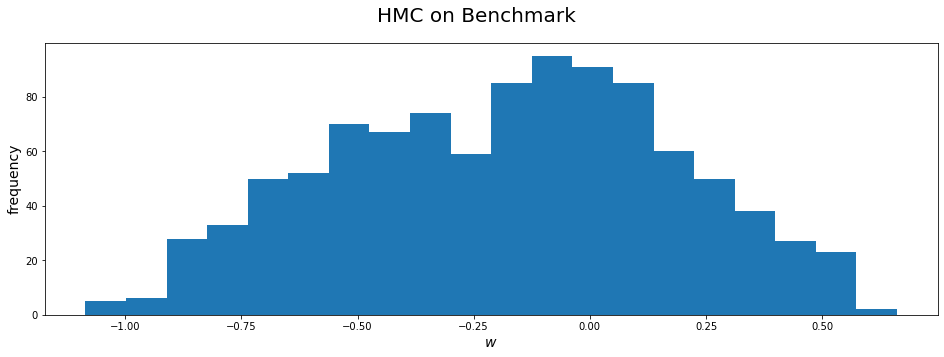

In [7]:
# Plot optimization history:
hmc_samples = hmc_benchmark.samples
fig, ax1 = plt.subplots(1,1,figsize=(16,5))
fig.suptitle("HMC on Benchmark", fontsize=20)
ax1.hist(hmc_samples, bins=20)
ax1.set_xlabel("$w$", fontsize=14)
ax1.set_ylabel("frequency", fontsize=14)
plt.show()


In [8]:
# # Save samples and random state:
# hmc_benchmark.save_state('../outputs/hmc_state.json', replace=False)


In [9]:
# # Load samples and random state:
# hmc_benchmark.load_state('../outputs/hmc_state.json')
